# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.


###Import Libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files




---


###UPLOAD IMAGES FOR STYLE TRANSFER



In [2]:
# Use this code to upload images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((333,500)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving IMG_6026 copy.jpg to IMG_6026 copy.jpg

Upload Style Image


Saving 00.jpg to 00.jpg
Content Path: <_io.BytesIO object at 0x7f73f197cf10>
Style Path: <_io.BytesIO object at 0x7f73f19960a0>


In [0]:
# After the images are uploaded on to the local filesystem, use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


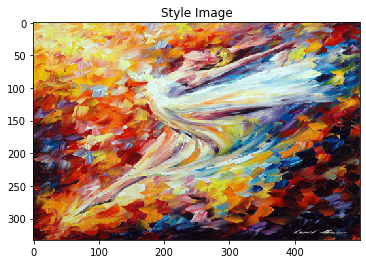

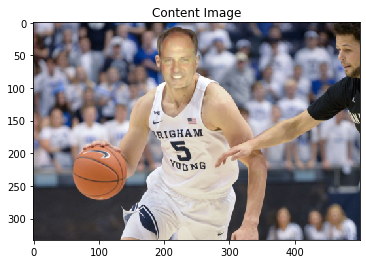

In [4]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Layer Extraction
Class to extract the layers needed for statistics


In [0]:
 import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval().cuda()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]
content_layers_default = [vgg_names.index(name) for name in ['conv4_2']]
style_layers_default = [vgg_names.index(name) for name in ['conv1_1', 'conv2_1','conv3_1','conv4_1','conv5_1']]

content_model = VGGIntermediate(content_layers_default)
content_out = content_model(content_image)
style_model = VGGIntermediate(style_layers_default)
style_out = style_model(style_image)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


___

### Model Loss Classes
Classes for the style and content loss



In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        #print(input,self.target)
        self.loss = F.mse_loss(input, self.target)
        #print(self.loss)
        return self.loss
    
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return self.loss

class StyleLossFunctions():
    def __init__(self,style_out):
        super(StyleLossFunctions, self).__init__()
        self.functions = [StyleLoss(target) for target in style_out.values()]

C_loss_1 = ContentLoss(list(content_out.values())[0])
#print(C_loss_1.target)
S_loss = StyleLossFunctions(style_out).functions
# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison


___

### TRAINING

Method that minimizes the content and style loss for a copy of the content image


In [0]:
C_losses = []
S_losses = []
domain = []
def neural_paint(style_val,content_val,lr=.01,iterations=100):

    content_copy = content_image.clone()
    optimizer = optim.Adam([content_copy.requires_grad_()], lr)
    loop = tqdm(total = iterations, position = 0)
    for i in range(iterations):
        optimizer.zero_grad()
        S_train_out = list(style_model(content_copy).values())
        C_train_out = list(content_model(content_copy).values())[0]
        style_loss = sum([loss_func.forward(S_train_out[i]) for i,loss_func in enumerate(S_loss)])
        content_loss = C_loss_1.forward(C_train_out)
        total_loss = content_loss*content_val+style_loss*style_val
        total_loss.backward()
        loop.set_description("loop # "+str(i)+' style_loss:{:.5f}'.format(style_loss)+' content_loss:{:.5f}'.format(content_loss))
        loop.update(1)
        if i % 20 == 0:
            domain.append(i)
            C_losses.append(content_loss)
            S_losses.append(style_loss)
        content_copy.data.clamp_(0, 1)     
        optimizer.step()
    loop.close()

    return content_copy.data.clamp_(0, 1)

  
# Show the image

In [11]:
output = neural_paint(1000000000,0,.004,1000)

loop # 999 style_loss:0.00020 content_loss:119.57868: 100%|██████████| 1000/1000 [02:27<00:00,  6.51it/s]


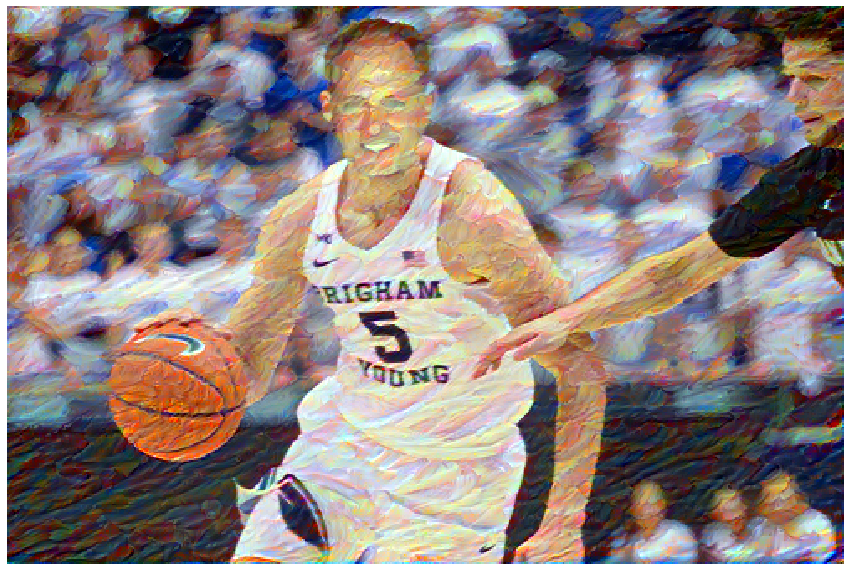

In [13]:
plt.figure(figsize=(15,20))
plt.imshow(torch.transpose(torch.transpose(output[0,:,:,:], 0,2),0,1).cpu())
plt.axis("off")
plt.show()



In [0]:
plt.figure(figsize=(10,5))
plt.plot(domain, C_losses, label = "Content Loss")
plt.plot(domain,S_losses,label = "Style Loss")
plt.ylabel("Error")
plt.xlabel("Training Loop")
plt.title("Loss vs Time")
plt.legend()
